# Project 2 FASHIONMNIST DATASET
## GAN:-
Generative Adversarial Networks (GANs) are a powerful class of neural networks that are used for unsupervised learning.
GANs are basically made up of a system of two competing neural network models which compete with each other and are able to analyze, capture and copy the variations within a dataset.
GANs can create images that look like photographs of human faces, even though the faces don't belong to any real person.

## Step 1: Importing the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
import os

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential , Model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,  Activation, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import *
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam, SGD

## Step 2:Loading the dataset from keras

In [ ]:
(X, y), (_, _) = keras.datasets.fashion_mnist.load_data()
X = X[y.flatten()==7] # selecting images labelled with 7

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
X.shape # 6000 images, with dimensions 28x28

(6000, 28, 28)

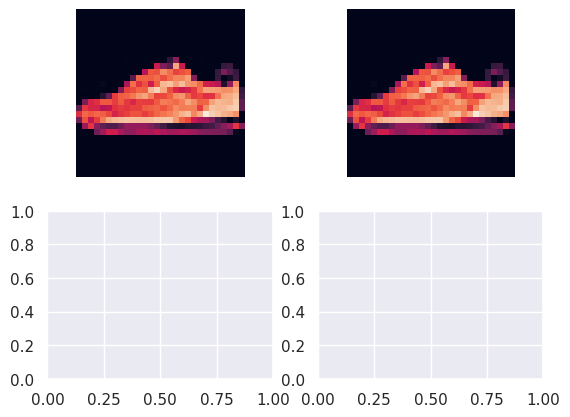

In [ ]:
fig, axs = plt.subplots(2,2) # This line creates a 2x2 grid of subplots. 'fig' is the figure object. 'axs' is 2d array representing each of the 2 subplots.
# count = 0
for i in range(2):
  for j in range(2):
    axs[i,j].imshow(X[4, :, :,]) # selecting the image at index 4. Double columns separated by comma indicate all rows and columns of the image are selected and the last comma is for selecting all color channels
    axs[i, j].axis('off') # removes axis information about the image
  # count +=1
  plt.show()
  plt.close()

## Step 3: Defining parameters to be used in later process
## Defining input shape

In [ ]:
image_shape = (28,28,1) 
latent_dimensions = 10

(28, 28, 1)


## Step 4: Defining a utility function to build the Generator Model

In [ ]:
def build_generator():

  model = Sequential() 
  # Building the input layer
  model.add(Dense(7 * 7 * 128, activation='relu', input_dim=latent_dimensions))
  # the first layer is a densely connected (fully connected) layer with 128*7*7 neurons.
  # relu introduces non-linearity in the model.

  model.add(Reshape((7,7,128)))
  # after the dense layer, the output is reshaped to form a 3d tensor of shape (7,7,128), this is done to prepare for the subsequent convolutional layers.
  
  model.add(UpSampling2D())
  # upsampling 2d doubles the size of the image in both height and width dimensions.

  model.add(Conv2D(128, kernel_size=3, padding="same"))
  # 128 is the no. of filters. Each filter learns different patterns or features in the input data.
  # kernel size is 3, meaning the filter will slide over input image and scan a 3x3 region at a time.

  model.add(BatchNormalization(momentum=0.78))
  # Batch normalization is a technique that helps stabilize and accelerate the training process in deep neural networks.
  # It normalizes the activations of the previous layer for each batch of data, making the optimization process smoother and reducing the impact of vanishing or exploding gradients.
  # The momentum=0.78 parameter controls how fast the batch normalization adapts to changes during training. A value close to 1 means it adapts slowly, and a value closer to 0 means it adapts faster.

  model.add(Activation("relu"))
  model.add(UpSampling2D())
  model.add(Conv2D(1, kernel_size=3, padding="same"))
  model.add(Activation("tanh"))
  
  # Generating the output image
  noise = Input(shape=(latent_dimensions, ))
  image = model(noise)
  
  return Model(noise, image)


## Step 5: Defining a utility function to build the Discriminator model

In [ ]:
from keras.layers import *
#from keras.layers import LeakyRelu


def build_discriminator():
  # Building convnet
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, strides=2, padding="same", input_shape= image_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  # model.add(ZeroPadding2D(padding=((0,1), (0,1))))
  model.add(BatchNormalization(momentum=0.82))
  model.add(LeakyReLU(alpha=0.25))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.82))
  model.add(LeakyReLU(alpha=0.25))
  model.add(Dropout(0.25))

  # Building output layer by using DNN
  model.add(Flatten())
  #model.add(Dense(128, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  image = Input(shape=image_shape)
  validity = model(image)

  return Model(image, validity)

## Step 6:Defining a utility function to display the generated images

In [ ]:
def display_images():
  r, c = 4,4
  noise = np.random.normal(0,1, (r * c, latent_dimensions))
  generated_images = generator.predict(noise)


  # scaling the generated images
  generated_images = 0.5*generated_images + 0.5

  fig, axs = plt.subplots(r, c)
  count = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(generated_images[count, :,:,])
      axs[i, j].axis('off')
      count +=1
  plt.show()
  plt.close()

## Step 7: Building the Generative Adversarial Network and compiling the discriminator

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5), metrics=['accuracy'])

discriminator.trainable = False

## Step 8: Building the generator and checking the validity of the generated image

In [ ]:
generator = build_generator()
z = Input(shape=(latent_dimensions, ))
image = generator(z)

valid = discriminator(image)


## Step 9: Defining the combined model of the Generator and Discriminator

In [ ]:
combined_network = Model(z, valid)

combined_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

##  Step 10: Final Step - Training the network

In [ ]:
# num_epochs = 50
num_epochs = 500
batch_size =32
display_interval = 10
# display_interval = 20
losses=[]

# Normalizing the input data
X = (X/127.5) - 1.

# Defining the Adversarial ground truths
valid = np.ones((batch_size, 1))

# adding some noise

valid +=0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake +=0.05*np.random.random(fake.shape)

for epoch in range(num_epochs):
  # training the discriminator
  # sampling a random half of images
  index = np.random.randint(0, X.shape[0], batch_size)
  images = X[index]

  # sampling noise and generating a batch of new images
  noise = np.random.normal(0,1, (batch_size, latent_dimensions))
  generated_images = generator.predict(noise)

  # Training the discriminator to detect more accurately whether a generated image is real or fake
  discm_loss_real = discriminator.train_on_batch(images, valid)
  discm_loss_fake = discriminator.train_on_batch(generated_images, fake)
  discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake)

  # traing the generatorn to generat image
  genr_loss = combined_network.train_on_batch(noise, valid)

  # Tracking the progress
  if epoch % display_interval ==0:
    display_images()

Output hidden; open in https://colab.research.google.com to view.

## Step 11: Plotting more image

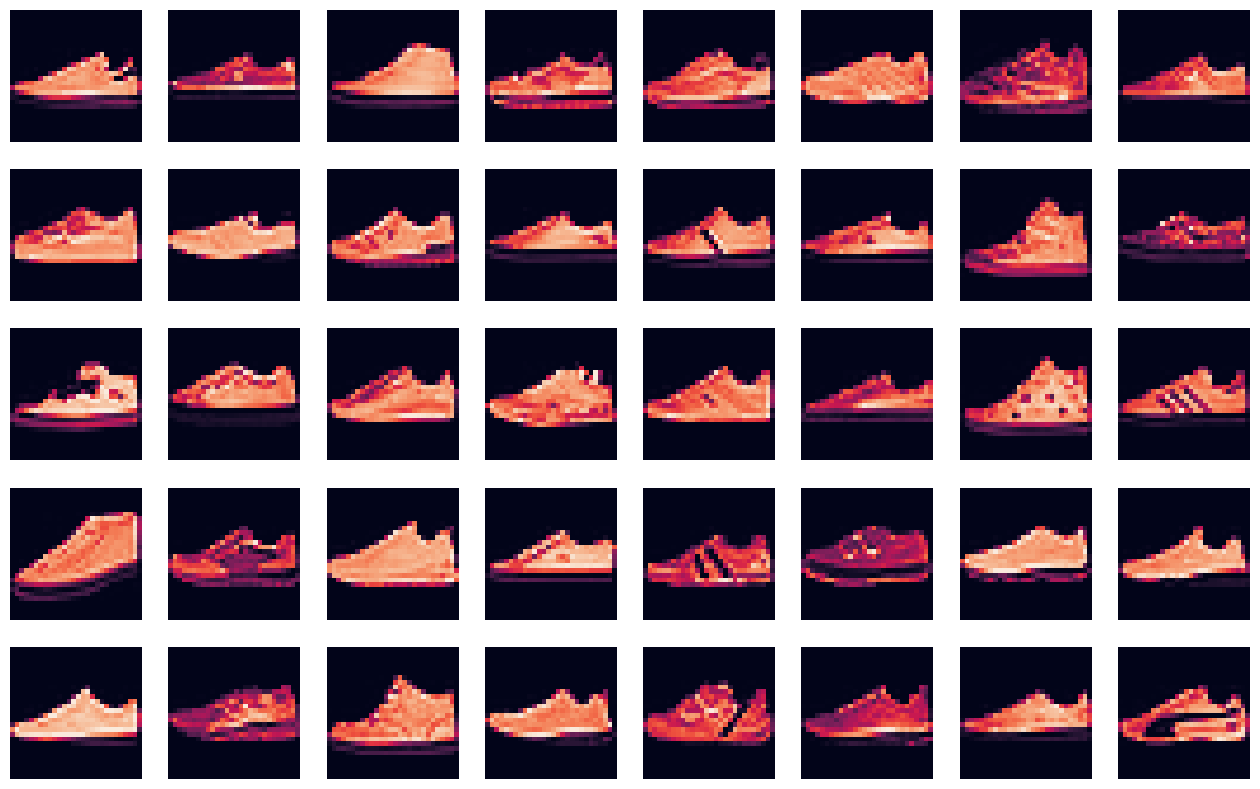

In [ ]:
s = X[:40]
s = 0.5 * s + 0.5

f, ax = plt.subplots(5,8, figsize=(16,10))
for i , image in enumerate(s):
  ax[i//8, i%8].imshow(image)
  ax[i//8, i%8].axis("off")

plt.show()

## Step 12: Plotting some of the last batch of generated images

2/2 [==============================] - 0s 85ms/step


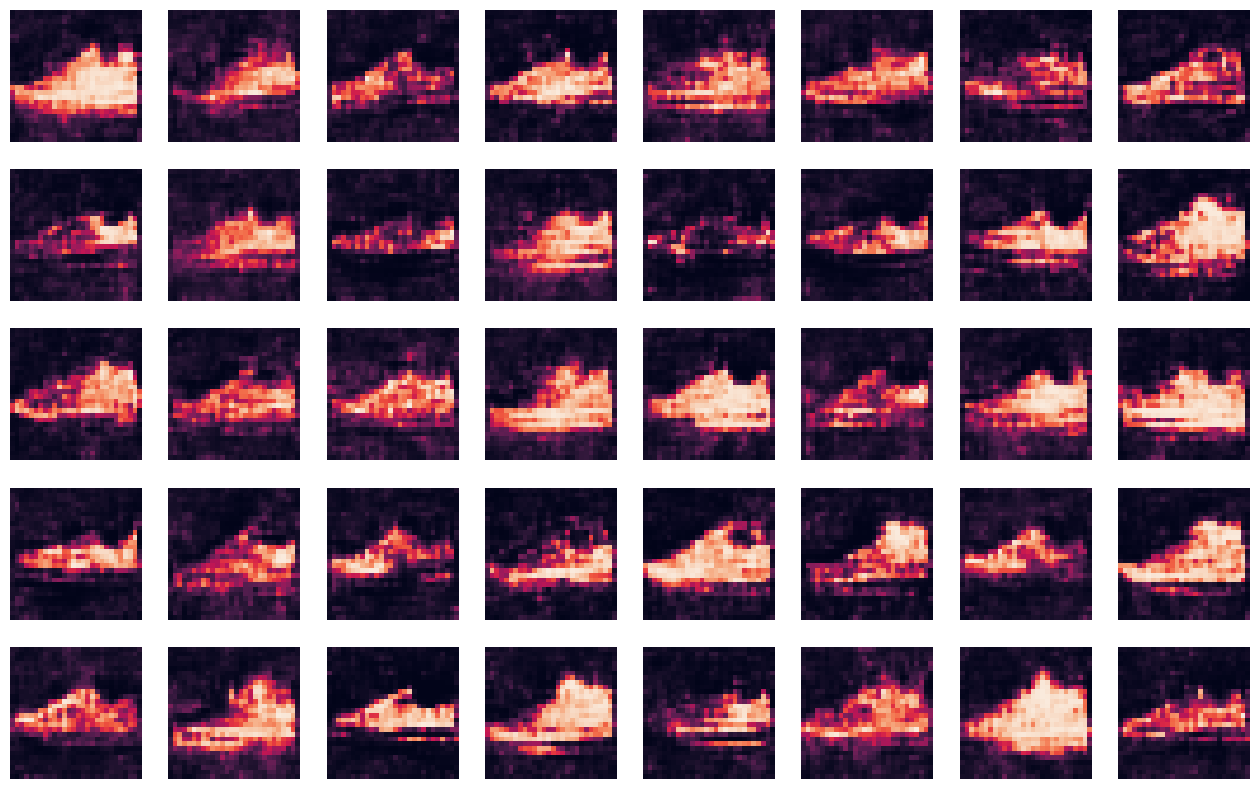

In [ ]:
noise = np.random.normal(size=(40, latent_dimensions))
generated_images = generator.predict(noise)

generated_images = 0.5*generated_images + 0.5

f, ax = plt.subplots(5,8, figsize=(16,10))
for i , image in enumerate(generated_images):
  ax[i//8, i%8].imshow(image)
  ax[i//8, i%8].axis("off")


plt.show()

## Conclusion:- We were able to generate some images out of the noise data collected from fashion mnist dataset